<a href="https://colab.research.google.com/github/mkirby1995/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/Model_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Define Problem and Assemble Dataset

We are attempting to predict the number of bikers crossing the Fremont Bridge on a given day. We will be using a regresion model.

In [1]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1616k    0 1616k    0     0   914k      0 --:--:--  0:00:01 --:--:--  914k


In [2]:
!wget https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv

--2019-05-15 20:43:38--  https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 234945 (229K) [text/plain]
Saving to: ‘BicycleWeather.csv.2’

BicycleWeather.csv. 100%[===================>] 229.44K  --.-KB/s    in 0.03s   

2019-05-15 20:43:38 (7.96 MB/s) - ‘BicycleWeather.csv.2’ saved [234945/234945]



In [0]:
import pandas as pd

# Download and join data into a dataframe
def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

daily = load()



---



# 2. Choose a Measure of Success

In [0]:
from sklearn.metrics import mean_absolute_error



---



# 3. Decide on an Evaluation Protocol

We will use cross validation to validate our model.

In [0]:
from sklearn.model_selection import cross_validate

In [6]:
train = daily[:-100] # everything but the last 100 days
test  = daily[-100:] # last 100 days
train.shape, test.shape

((963, 8), (100, 8))

In [7]:
X_train = train.drop(columns='Total')
y_train = train['Total']

X_test  = test.drop(columns='Total')
y_test  = test['Total']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((963, 7), (963,), (100, 7), (100,))



---



# 4. Prepare the Data

In [0]:
import numpy as np

def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))

    
    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10
    
    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])

    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

X_train = jake_wrangle(X_train)



---



# 5. Devlop a Model That Does Better Than a Baseline 

In [9]:
day_before = X_train['Total_yesterday']
mean_absolute_error(y_train, day_before)

708.061266874351

In [10]:
from sklearn.linear_model import LinearRegression

scores = cross_validate(LinearRegression(), X_train, y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True, return_estimator=True)

pd.DataFrame(scores)

,fit_time,score_time,estimator,test_score,train_score
0,0.005627,0.001703,"LinearRegression(copy_X=True, fit_intercept=Tr...",-297.692524,-294.532315
1,0.003900,0.001768,"LinearRegression(copy_X=True, fit_intercept=Tr...",-300.419037,-283.779461
2,0.004225,0.001524,"LinearRegression(copy_X=True, fit_intercept=Tr...",-322.640378,-283.509114


In [11]:
-scores['test_score'].mean()

306.9173130794428



---



# 6. Develop a Model That Overfits

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

param_distributions = {
    'n_estimators': [100], 
    'max_depth': [5, 10, 15, None], 
    'criterion': ['mae']
}

gridsearch = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=4, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   22.6s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=4, n_jobs=-1,
          param_distributions={'n_estimators': [100], 'max_depth': [5, 10, 15, None], 'criterion': ['mae']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [13]:
random_forest_gridsearch_results = pd.DataFrame(gridsearch.cv_results_).sort_values(by='rank_test_score')
random_forest_gridsearch_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,3.407137,0.065209,0.114477,0.003932,100,15,mae,"{'n_estimators': 100, 'max_depth': 15, 'criter...",-347.235405,-319.651340,-304.428754,-323.771833,17.716963,1,-112.552009,-102.188061,-116.336075,-110.358715,5.980495
1,3.141376,0.112278,0.117118,0.002718,100,10,mae,"{'n_estimators': 100, 'max_depth': 10, 'criter...",-349.442196,-324.468287,-297.640561,-323.850348,21.152443,2,-143.936106,-128.380117,-145.615195,-139.310472,7.759267
3,3.392422,0.172259,0.114496,0.007602,100,None,mae,"{'n_estimators': 100, 'max_depth': None, 'crit...",-358.797290,-320.268505,-301.250794,-326.772196,23.939135,3,-108.845631,-99.839463,-113.803692,-107.496262,5.780168
0,2.458001,0.018934,0.110908,0.008861,100,5,mae,"{'n_estimators': 100, 'max_depth': 5, 'criteri...",-360.615374,-387.242134,-335.736137,-361.197882,21.031269,4,-299.174914,-266.206192,-294.979984,-286.787030,14.653271




---



# 7. Regularize the Model and Tune its Hyperparameters

In [0]:
!pip install eli5
!pip install pdpbox
!pip install shap

In [15]:
model = gridsearch.best_estimator_
model

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [16]:
!pip install category_encoders

In [18]:
import category_encoders as ce
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='neg_mean_absolute_error', cv='prefit', 
                                 n_iter=2, random_state=42)

permuter.fit(X_train.values, y_train)

PermutationImportance(cv='prefit',
           estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
           n_iter=2, random_state=42, refit=True,
           scoring='neg_mean_absolute_error')

In [19]:
feature_names = X_train.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
387.5404 ± 10.2116,Total_yesterday
306.7712 ± 29.0518,TMAX
275.2800 ± 10.2900,Sat
192.8133 ± 7.4095,PRCP
173.4031 ± 3.7680,Sun
144.0828 ± 2.5666,daylight_hrs
81.4460 ± 7.5825,Mon
35.2123 ± 2.2156,annual
34.0110 ± 2.2685,AWND
26.9140 ± 0.3254,TMIN


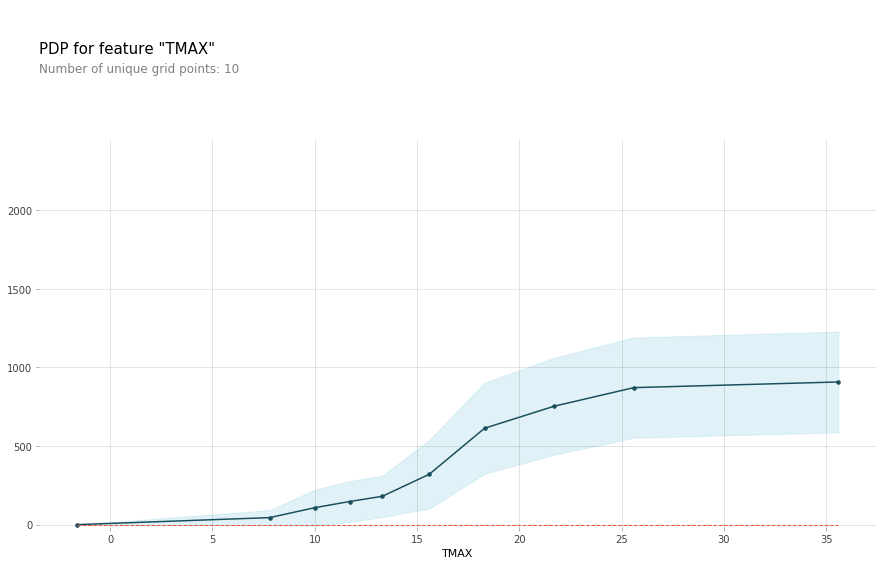

In [21]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'TMAX'

isolated = pdp_isolate(
    model=model, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

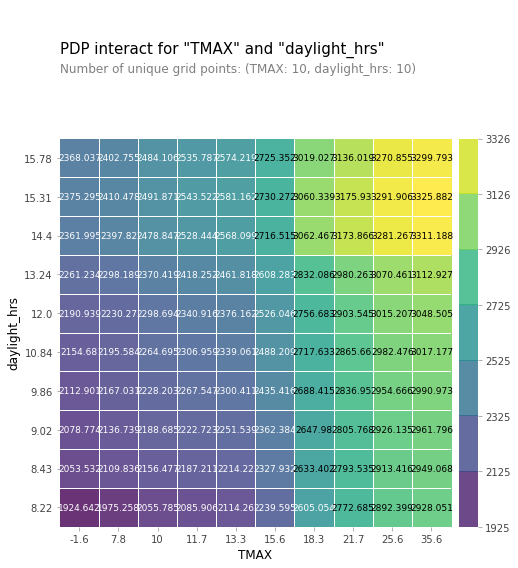

In [33]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['TMAX', 'daylight_hrs']

interaction = pdp_interact(
    model=model, 
    dataset=X_train, 
    model_features=X_train.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [31]:
data_for_prediction = X_train.iloc[[3]]
data_for_prediction

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry day,annual
2012-10-07,0.0,0,0,23.9,7.8,13,2006.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,15.85,1,0.008219


In [32]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)



---

